This notebook walks through the preprocessing workflow described in the course slides.

In [64]:
import os
try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/ds003'
print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from compute_fd_dvars import compute_fd,compute_dvars


Using data from /Users/poldrack/data_unsynced/ds003


Load the data for a subject with bad motion

In [31]:
subject='sub004'  # this subject has bad motion

bolddir=os.path.join(basedir,subject,'BOLD/task001_run001')
boldfile=os.path.join(bolddir,'bold.nii.gz')
boldimg=nibabel.load(boldfile)
bolddata=boldimg.get_data()

Perform motion correction using FSL's mcflirt - this will take about a minute.

In [32]:
mcf_boldfile=boldfile.replace('.nii.gz','_mcf.nii.gz')
mcflt = fsl.MCFLIRT(in_file=boldfile,
                    out_file=mcf_boldfile,
                   save_plots=True)
result = mcflt.run() 

Compute the mean across timepoints and save to a file

In [36]:
boldimg=nibabel.load(mcf_boldfile)
bolddata=boldimg.get_data()

boldmean=numpy.mean(bolddata,3)
meanimg=nibabel.Nifti1Image(boldmean,affine=boldimg.get_affine())
meanboldfile=os.path.join(bolddir,'bold_mcf_mean.nii.gz')
meanimg.to_filename(meanboldfile)

Use FSL's BET to obtain the brain mask

In [38]:
meanbrainfile=meanboldfile.replace('.nii.gz','_brain.nii.gz')
bet = fsl.BET()
bet.inputs.in_file = meanboldfile
bet.inputs.out_file = meanbrainfile
bet.inputs.mask=True
bet = bet.run() 

Display the mean image, and show the outline of the brain mask.

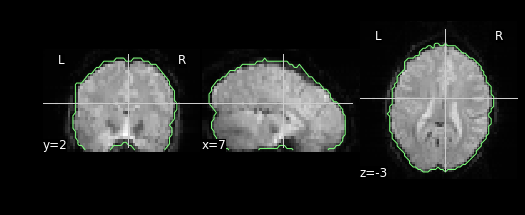

In [44]:
meanbrainmask=nibabel.load(meanbrainfile.replace('_brain','_brain_mask'))
maskdata=meanbrainmask.get_data()

mask_display=nilearn.plotting.plot_epi(meanimg,cmap='gray')
mask_display.add_contours(meanbrainmask, levels=[.5]) 

Compute and plot the global signal within the mask across timepoints

In [52]:
maskvox=numpy.where(maskdata)
globalmean=numpy.zeros(bolddata.shape[3])
globalcv=numpy.zeros(bolddata.shape[3])
for t in range(bolddata.shape[3]):
    tmp=bolddata[:,:,:,t]
    globalmean[t]=numpy.mean(tmp[maskvox])
    globalcv[t]=numpy.std(tmp[maskvox])/numpy.mean(tmp[maskvox])
    

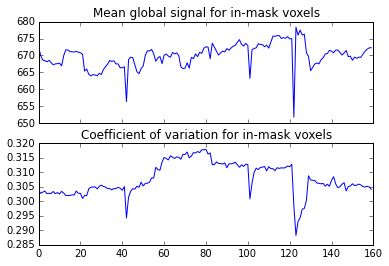

Load motion data and compute FD/DVARS

In [66]:
motionfile=mcf_boldfile+'.par'
motiondata=numpy.loadtxt(motionfile)
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)

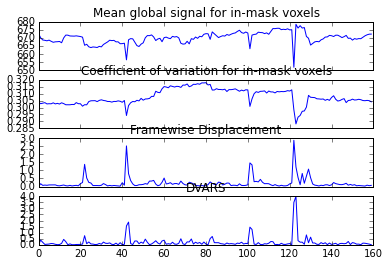

In [69]:
f, (ax1, ax2,ax3,ax4)=plt.subplots(4, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(globalcv)
ax2.set_title('Coefficient of variation for in-mask voxels')

ax3.plot(fd)
ax3.set_title('Framewise Displacement')

ax4.plot(dvars)
ax4.set_title('DVARS')


Run independent components analysis on the data using MELODIC

In [ ]:
melodic=fsl.MELODIC(out_all=True)
melodic.inputs.in_files=mcf_boldfile
melodic.inputs.out_dir=mcf_boldfile.replace('.nii.gz','.ica')
melodic.run()